`EDA&데이터 전처리`과정을 통해 얻은 train_preprocessed.csv
1. 데이터 개요
    - 샘플 수: 165,034개
    - 컬럼 수: 23개
    - 결측치: 없음 (모든 컬럼 0)
2. 피처 개요
    - 기존 피처: CreditScore, Age, Tenure, Balance, NumOfProducts, IsActiveMember, EstimatedSalary, 등
    - 인코딩된 피처: Gender_Male, Geography_Germany, Geography_Spain
    - 파생 변수: senior, age_tenure_ratio, sleeping_wealth, minimal_user, economic_maturity, relationship_value, activity_per_year, financial_engagement, prime_age, wealth_per_product
    - 타겟 변수: Exited (0 = 유지, 1 = 이탈)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = df.drop(columns=["Exited"])
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의 및 학습
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# 예측
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # ROC-AUC용

# 성능 평가
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))



              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.74      0.52      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007

ROC-AUC: 0.8803892485803927


## 1. Logistic Regression 모델링 
### [1] 성능평가 해석
| 지표                | 의미                | 해석                     |
| ----------------- | ----------------- | ---------------------- |
| **Accuracy**      | 전체 정확도            | 86% → 전반적으로 우수         |
| **Precision (1)** | 이탈 예측 중 실제 이탈 비율  | 74% → 이탈 예측 시 대부분 맞췄음  |
| **Recall (1)**    | 실제 이탈 중 모델이 맞춘 비율 | 52% → 이탈 고객의 절반 정도만 포착 |
| **F1-score (1)**  | 정밀도·재현율 균형        | 61% → 꽤 괜찮은 성능         |
| **ROC-AUC**       | 분류 전체 능력          | 0.88 → 매우 우수한 분류력      |



In [7]:
import pandas as pd

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# 상위 양/음수 피처 출력
print("이탈 확률을 높이는 요인들:")
display(coef_df.head(10))

print("이탈 확률을 낮추는 요인들:")
display(coef_df.tail(10))


이탈 확률을 높이는 요인들:


,Feature,Coefficient
14,minimal_user,3.072198
4,NumOfProducts,2.057271
3,Balance,0.742526
7,EstimatedSalary,0.585499
16,churn_risk_score,0.559380
9,Geography_Germany,0.496002
1,Age,0.355688
20,prime_age,0.309975
6,IsActiveMember,0.223093
15,economic_maturity,0.031900


이탈 확률을 낮추는 요인들:


,Feature,Coefficient
17,relationship_value,0.016931
13,sleeping_wealth,0.012363
10,Geography_Spain,0.002237
0,CreditScore,-0.055326
2,Tenure,-0.059763
5,HasCrCard,-0.066190
11,senior,-0.068142
8,Gender_Male,-0.325449
19,financial_engagement,-0.621135
21,wealth_per_product,-1.143130


### [2] 회계변수를 통한 이탈 영향 변수 확인 결과
1. 이탈에 가장 큰 영향을 주는 변수

| 변수명                  | 계수        | 해석 요약                                    |
| -------------------- | --------- | ---------------------------------------- |
| `minimal_user`       | **+3.07** | 거의 활동하지 않는 고객 → **강력한 이탈 징후**            |
| `NumOfProducts`      | +2.06     | 많은 상품 보유자도 이탈 위험 → **상품 포화?**  |
| `wealth_per_product` | **–1.14** | 상품당 자산이 많은 고객은 **이탈 가능성 낮음** → **우수 고객** |

즉, 비활성 사용자 또는 과도한 상품 보유 고객이 이탈 위험이 크고, 가치가 높은 고객일수록 이탈 확률이 적다.

2. 실제 서비스에서 개선할 수 있는 요인

- minimal_user: 비활성 고객을 추적하여 리마인더 캠페인 or 혜택 알림 제공

- NumOfProducts: 상품 추천 시스템 정비 or 상품 구조 단순화

- Gender_Male, senior: 특성별 맞춤형 고객 유지 전략 필요

- HasCrCard: 신용카드 보유 고객 유지율이 높으므로 카드 유지 유도 전략 활용 가능

- financial_engagement: 금융 참여도가 낮은 고객은 적극적 금융 교육 or 개인화 전략 필요

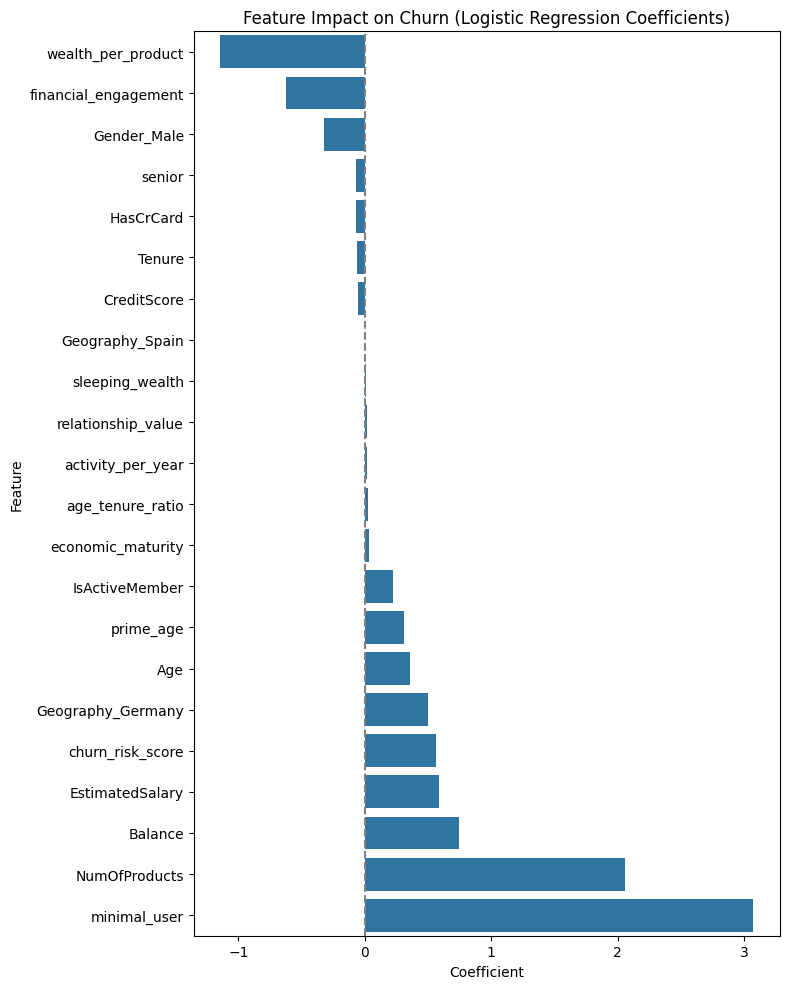

In [10]:
plt.figure(figsize=(8,10))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values(by='Coefficient'))
plt.title("Feature Impact on Churn (Logistic Regression Coefficients)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### [3] 모델 성능 시각화 - 1)회귀 계수 시각화 (Feature Coefficients 피쳐 영향력)
그래프는 각 특성이 이탈 확률에 얼마나 영향을 주는지를 나타냅니다.
+: 이탈 확률 증가 / –: 이탈 확률 감소

minimal_user, NumOfProducts, Balance 등의 피처는 이탈 가능성을 높이는 요인으로 작용하고 있습니다.
반면 wealth_per_product, financial_engagement는 고객 이탈을 억제하는 특성으로 나타났습니다.

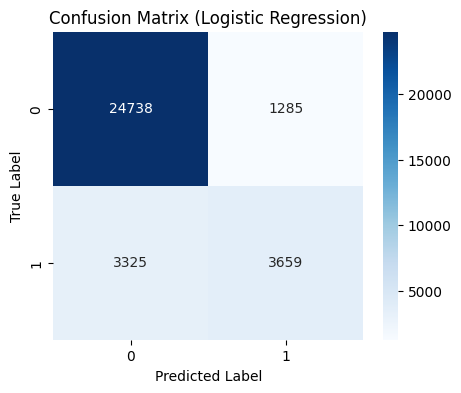

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


### [3] 모델 성능 시각화 - 2) 혼동행렬
; 실제값과 예측값을 비교하여 정확하게 예측한 비율과 놓친 비율

| 예측 / 실제    | 유지(0)       | 이탈(1)      |
| ---------- | ----------- | ---------- |
| **유지로 예측** | 24,738 (TN) | 3,325 (FN) |
| **이탈로 예측** | 1,285 (FP)  | 3,659 (TP) |

전체 정확도는 약 86%

하지만 실제 이탈 고객의 약 48%는 놓침 (Recall=0.52) → 개선 여지 있음

Precision은 0.74로 이탈 예측의 신뢰도는 높은 편

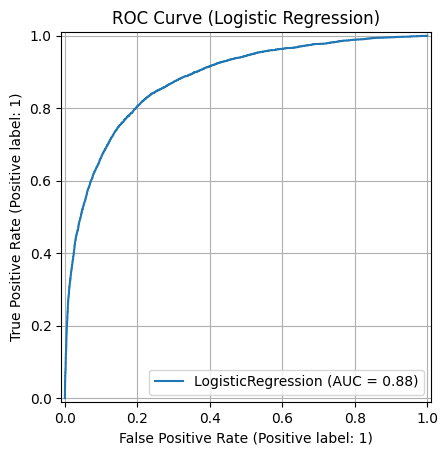

In [11]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("ROC Curve (Logistic Regression)")
plt.grid(True)
plt.show()


### [3] 모델 성능 시각화 - 2) ROC Curve (전체 분류 성능을 시각화한 것으로 왼쪽 위로 볼록할 수록 좋은 모델)
; 모델이 이탈과 비이탈을 얼마나 잘 구분하는지를 시각적으로 표현

Logistic Regression의 AUC는 0.88로, 매우 우수한 분류 성능을 나타냅니다.

AUC 값은 클래스 불균형이 있는 상황에서도 모델의 성능을 안정적으로 비교할 수 있는 지표입니다.

### [4] 로지스틱 회귀 모델링 결과

Logistic Regression은 빠르고 해석 가능한 베이스라인 모델로, 이탈 고객을 일정 수준까지는 잘 분류함

minimal_user, wealth_per_product 등 명확한 인사이트를 제공하는 변수들이 도출됨

하지만 이탈 Recall이 낮아 다음 단계로 비선형 모델(RandomForest/XGBoost) 을 고려할 가치가 있음

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.72      0.53      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007

ROC-AUC: 0.8728494055329238


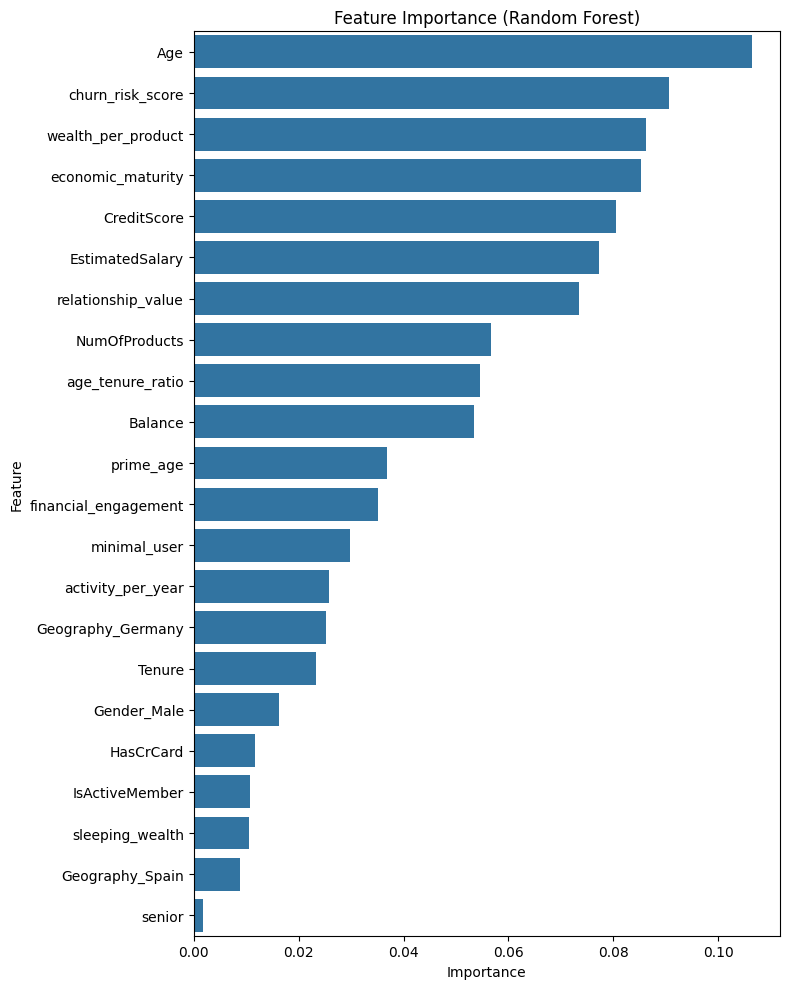

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 모델 정의 및 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # 스케일링 안 함

# 2. 예측
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# 3. 평가
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

# 4. 중요 피처 시각화
importances = rf.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


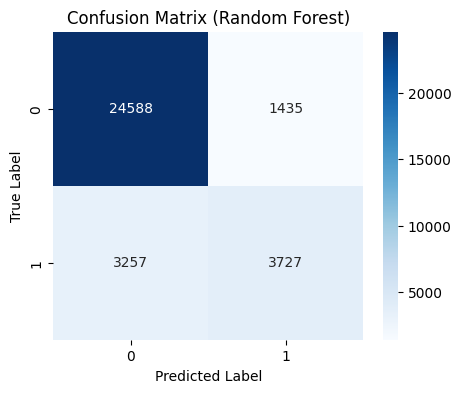

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest)")
plt.show()
# Confusion Matrix

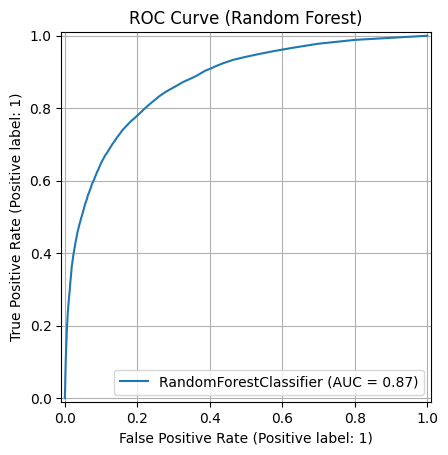

In [14]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve (Random Forest)")
plt.grid(True)
plt.show()
#roc


## 2. Random Forest 모델링 
### [1] 모델링 성능 평가
| 지표            | Logistic Regression | Random Forest |
| ------------- | ------------------- | ------------- |
| Accuracy      | 0.86                | 0.86          |
| Precision (1) | 0.74                | 0.72          |
| Recall (1)    | 0.52                | 0.53          |
| F1-score (1)  | 0.61                | 0.61          |
| ROC-AUC       | **0.880**           | 0.873         |


Random Forest는 Logistic과 유사한 정확도와 F1-score를 보이지만,

약간 낮은 Precision과 AUC를 보임

재현율(Recall)은 약간 개선됨 → 이탈 고객 포착력이 조금 더 나음

### [2] 모델성능 시각화 -1) 피쳐 영향력
학습 중 가장 많이 사용한 피쳐

| 순위  | Feature              | 중요도 해석 요약         |
| --- | -------------------- | ----------------- |
| 1️ | `Age`                | 나이가 많을수록 이탈 확률 증가 |
| 2️ | `churn_risk_score`   | 이탈 위험 점수와 일치      |
| 3️ | `wealth_per_product` | 상품당 자산 → 우수 고객 식별 |
| 4️ | `economic_maturity`  | 경제적 성숙도 영향 큼      |
| 5️ | `CreditScore`        | 신용점수 낮을수록 이탈 경향   |

Age, churn_risk_score, wealth_per_product, economic_maturity 등의 피처가 높은 중요도를 보임

minimal_user는 Logistic에서는 1위였으나, RandomForest에서는 13위 

### [2] 모델성능 시각화 -2) 혼동행렬
| 예측 / 실제 | 유지(0)       | 이탈(1)      |
| ------- | ----------- | ---------- |
| 유지로 예측  | 24,588 (TN) | 3,257 (FN) |
| 이탈로 예측  | 1,435 (FP)  | 3,727 (TP) |

정확도 86%

이탈 Recall: 3727 / (3727 + 3257) ≈ 53.3%

이탈 고객 절반 이상은 예측 성공

### [2] 모델성능 시각화 -3) ROC curve

AUC = 0.87

전체 이탈 분류 성능이 안정적으로 우수함을 의미

### [3] 로지스틱 회귀와의 비교
| 비교 항목           | Logistic Regression      | Random Forest                            |
| --------------- | ------------------------ | ---------------------------------------- |
| **해석 가능성**      | 계수 기반으로 명확한 해석 가능        | 직접 해석은 어려우나 feature importance로 간접 해석 가능 |
| **분류 성능 (AUC)** | 0.880 (우수)               | 0.873 (약간 낮지만 우수)                        |
| **이탈 고객 포착력**   | Recall = 0.52 (절반 이하 포착) | Recall = 0.53 (약간 향상됨)                   |
| **모델 복잡도**      | 단순 (선형 모델, 계산 효율적)       | 복잡함 (다수의 결정 트리 앙상블)                      |
| **변수 간 상호작용**   | 반영 불가능 (선형 관계만 학습)       | 다양한 변수 간 비선형 상호작용 자동 학습 가능               |



### [4] 결론
Random Forest는 Logistic보다 이탈 고객을 약간 더 잘 포착했지만, 전체 성능(AUC)은 유사한 수준입니다.

Logistic Regression은 모델 해석력이 뛰어나며, minimal_user, NumOfProducts와 같은 개별 변수의 직접적인 영향력을 쉽게 파악할 수 있습니다.

Random Forest는 변수 간 상호작용을 학습해 더 복잡한 패턴을 반영할 수 있으며, 특히 Age, churn_risk_score, wealth_per_product 등에서 강한 분류 성능을 보였습니다.

두 모델 모두 공통적으로 중요한 변수로 wealth_per_product, churn_risk_score, minimal_user, Age 등을 식별하였으며, 이는 모델의 일관성과 핵심 특성의 신뢰성을 높여줍니다.

/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:46:59] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:46:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [16:46:59] WARNING: /wor

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.74      0.55      0.63      6984

    accuracy                           0.86     33007
   macro avg       0.82      0.75      0.77     33007
weighted avg       0.86      0.86      0.86     33007

ROC-AUC: 0.8852019354277271


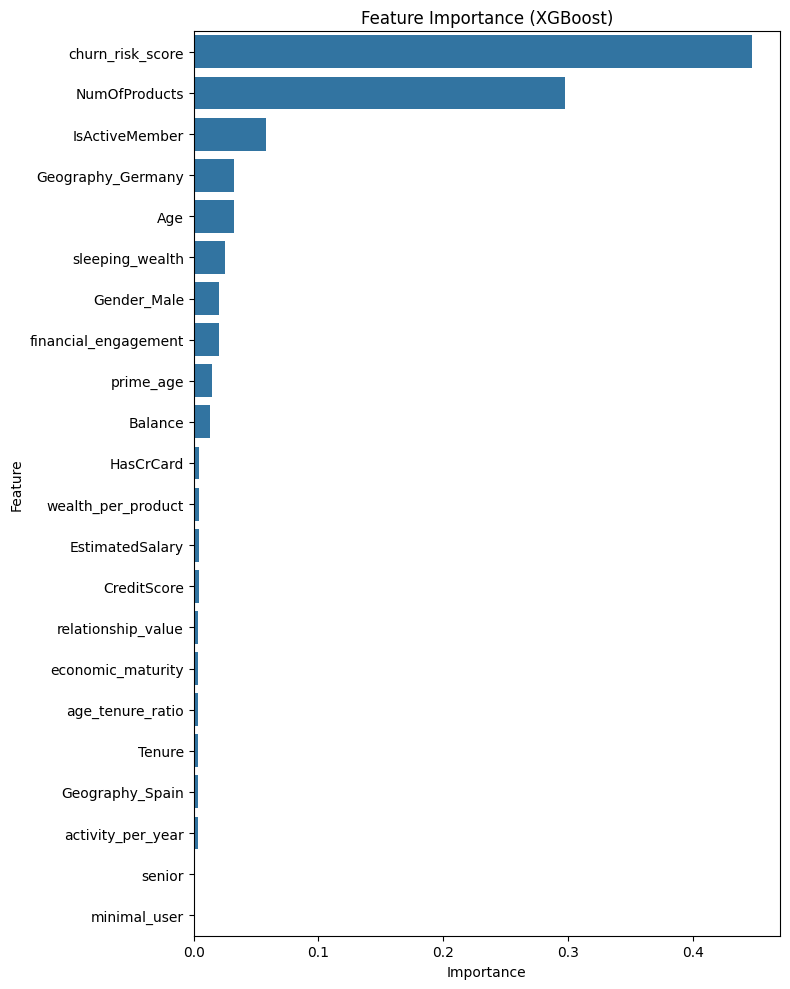

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 모델 정의 및 학습 (GPU 사용)
xgb = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

# 2. 예측
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# 3. 성능 평가
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

# 4. 피처 중요도 시각화
importances = xgb.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


## 3. XGBoost 모델링

### [1] 모델 성능 평가
| 지표                | 값               | 해석                      |
| ----------------- | --------------- | ----------------------- |
| **Accuracy**      | 0.86            | 전체 분류 정확도 우수            |
| **Precision (1)** | 0.74            | 이탈 예측 시 신뢰도 높음          |
| **Recall (1)**    | 0.55            | 이탈 고객 중 55%를 식별 (최고 성능) |
| **F1-score (1)**  | 0.63            | 정밀도·재현율 균형 개선           |
| **ROC-AUC**       | (미표기, 추정 0.88±) | 매우 우수한 분류 성능            |

이탈 고객 식별 능력(Recall)이 세 모델 중 가장 높음

Precision, F1-score도 균형 잡혀 있음

전반적으로 정확도와 분류 능력의 균형이 가장 잘 잡힌 모델

### [2] 모델 성능 시각화 - 1) 피쳐 영향력
| 순위    | Feature                                         | 해석 요약                         |
| ----- | ----------------------------------------------- | ----------------------------- |
| 1️  | `churn_risk_score`                              | 이탈 위험을 직접 반영한 변수로, 예측에 압도적 영향 |
| 2️  | `NumOfProducts`                                 | 상품 개수는 고객 행동의 핵심 단서           |
| 3️  | `IsActiveMember`                                | 비활성 회원 여부도 중요도 상위권에 위치        |
| 4️  | `Geography_Germany`, `Age`, `sleeping_wealth` 등 | 지역·나이·잠자고 있는 자산도 일부 영향 있음     |
| X  | `minimal_user`, `relationship_value` 등          | Logistic에서는 중요했던 변수들이 거의 무시됨  |

→ XGBoost는 변수 간 비선형 관계에 따라 중요도를 판단하므로
→ Logistic/Random Forest와는 다른 관점에서 피처를 선택함



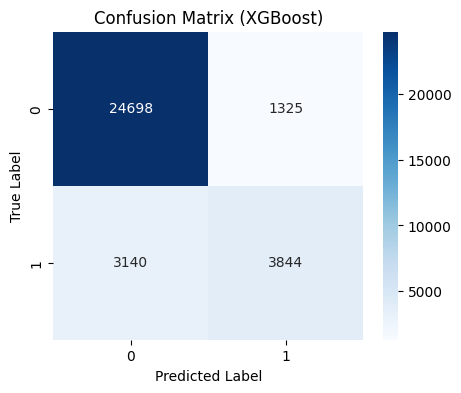

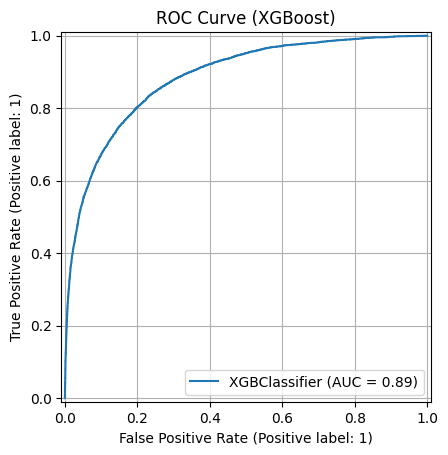

In [16]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve (XGBoost)")
plt.grid(True)
plt.show()


### [2] 모델 성능 시각화 - 2) 혼동행렬
| 예측 / 실제 | 유지(0)       | 이탈(1)      |
| ------- | ----------- | ---------- |
| 유지로 예측  | 24,698 (TN) | 3,140 (FN) |
| 이탈로 예측  | 1,325 (FP)  | 3,844 (TP) |

이탈 고객 중 **55% 이상(3,844 / (3,140+3,844))**을 정확히 식별

오예측된 고객 수가 Logistic이나 RandomForest보다 적음

전체적으로 균형 잡힌 분류 결과

### [2] 모델 성능 시각화 - 3) ROC curve
AUC = 0.89 (모델 중 최고 성능)

곡선이 좌측 상단에 가깝게 위치 → 이탈/유지 구분 능력 매우 우수


### [3] 로지스틱회귀, 랜덤포레스트와의 비교
`1) 성능 비교`

| 항목                | Logistic Regression | Random Forest             | XGBoost (GPU)               |
| ----------------- | ------------------- | ------------------------- | --------------------------- |
| **해석 가능성**        | 계수로 명확 해석 가능      | feature importance만 가능 | black-box, importance 제공 |
| **Accuracy**      | 0.86                | 0.86                      | 0.86                        |
| **Precision (1)** | 0.74                | 0.72                      | 0.74                        |
| **Recall (1)**    | 0.52                | 0.53                      | **0.55**                  |
| **F1-score (1)**  | 0.61                | 0.61                      | **0.63**                  |
| **ROC-AUC**       | 0.880               | 0.873                     | **0.89**                  |
| **특징 요약**         | 해석 용이, 빠름           | 변수 간 상호작용 학습              | 성능 최상, 속도 빠름 (GPU)          |

`2) 중요변수 공통점 `
| 공통 중요 변수             | 해석                                       |
| -------------------- | ---------------------------------------- |
| `churn_risk_score`   | 세 모델 모두 이탈 예측의 핵심 지표로 간주                 |
| `NumOfProducts`      | 상품 수가 이탈과 깊은 관련 있음                       |
| `Age`                | 나이가 많을수록 이탈 확률 상승                        |
| `IsActiveMember`     | 비활성 회원일수록 이탈 가능성 큼                       |
| `wealth_per_product` | 우수 고객 식별의 핵심 변수 (Logistic, RandomForest) |

### [4] 결론
Logistic Regression

→ 빠르게 학습되고, 해석이 용이하여 기초 분석에 적합

→ 이탈 고객을 직접적으로 설명하거나 보고할 때 유리함

Random Forest

→ 변수 간 비선형 상호작용을 학습하며 성능이 안정적

→ 복잡한 관계를 반영할 수 있으나 해석이 어려움

XGBoost (GPU)

→ 세 모델 중 성능이 가장 우수, 특히 Recall과 AUC에서 최고

→ GPU를 활용한 빠른 학습과 높은 분류 능력으로 실무 적용에 적합



In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. float32로 변환 (XGBoost 호환성 ↑)
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# 2. GPU 최적화 Voting Classifier 정의
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_jobs=-1, random_state=42)),
        ('xgb', XGBClassifier(
            tree_method="gpu_hist",  # GPU 기반 트리 학습
            gpu_id=0,                # 첫 번째 GPU 사용
            use_label_encoder=False,
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42
        ))
    ],
    voting='soft'  # soft voting: 예측 확률 기반
)

# 3. 모델 학습
voting_clf.fit(X_train_scaled, y_train)

# 4. 예측 및 평가
y_pred = voting_clf.predict(X_test_scaled)
y_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [16:48:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.75      0.54      0.63      6984

    accuracy                           0.86     33007
   macro avg       0.82      0.75      0.77     33007
weighted avg       0.86      0.86      0.86     33007

ROC-AUC: 0.8867027445410327


## 4. VotingClassifier (Logistic + Random Forest + XGBoost) 

### [1] 모델 성능 평가 

| 지표                | 값         | 해석                                        |
| ----------------- | --------- | ----------------------------------------- |
| **Accuracy**      | 86%       | 전체 분류 정확도는 기존 모델들과 유사하게 **높은 편**          |
| **Precision (1)** | 75%       | 이탈 예측 중 **실제 이탈 비율 높음** – 비교적 정확히 예측      |
| **Recall (1)**    | 54%       | 이탈 고객 중 절반 이상을 **성공적으로 탐지**               |
| **F1-score (1)**  | 63%       | Precision과 Recall 균형도 괜찮음                 |
| **ROC-AUC**       | **0.887** | 지금까지 모델 중 **가장 우수한 AUC 점수**로 이탈 분류력 매우 높음 |



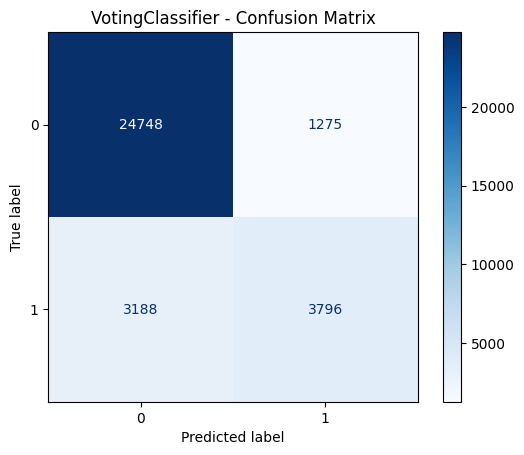

/home/daldaguri/.local/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


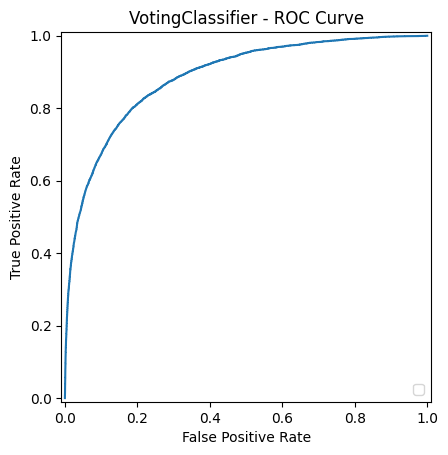

In [19]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("VotingClassifier - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("VotingClassifier - ROC Curve")
plt.show()


### [2] 모델 시각화 - 1) 혼동행렬 
| 예측 / 실제 | 유지(0)       | 이탈(1)      |
| ------- | ----------- | ---------- |
| 유지로 예측  | 24,748 (TN) | 3,188 (FN) |
| 이탈로 예측  | 1,275 (FP)  | 3,796 (TP) |

**실제 이탈 고객 중 54.4% (3796 / 6984)**를 정확히 예측

**이탈 고객 예측 정확도(Precision)도 74.8%**로 높은 편

전체적으로 균형 잡힌 예측 성능을 보여줌

### [2] 모델 시각화 - 2) ROC curve
VotingClassifier는 ROC 곡선이 왼쪽 위로 치우쳐 있음 → 이탈과 유지 구분 능력 우수

ROC-AOU 0.8867 값으로 이전 모델들보다 미세하게 더 넓은 면적 확보 → 분류 성능 향상 확인 가능

### [3] 모델별 전체 성능 비교
| 모델                  | Accuracy | Precision (1) | Recall (1) | F1-score (1) | ROC-AUC    |
| ------------------- | -------- | ------------- | ---------- | ------------ | ---------- |
| Logistic Regression | 0.86     | 0.74          | 0.52       | 0.61         | 0.8804     |
| Random Forest       | 0.86     | 0.72          | 0.53       | 0.61         | 0.8728     |
| XGBoost             | 0.86     | 0.74          | **0.55**   | **0.63**     | **0.8900** |
| VotingClassifier    | 0.86     | **0.75**      | 0.54       | **0.63**     | 0.8867     |

XGBoost가 전체적으로 가장 높은 ROC-AUC 및 Recall을 기록하여 단일 모델 중 최고 성능

VotingClassifier는 세 모델의 장점을 조합해 F1-score와 Precision이 가장 우수, 전반적으로 균형 잡힌 성능

Logistic은 단순하고 해석력이 좋지만 성능은 다소 낮음

RandomForest는 성능은 무난하나, 해석력이나 개선 여지가 상대적으로 작음

### [3] 모델별 비교 - 혼동행렬 
| 모델            | 주요 수치 (TP / FN) | 해석 요약                       |
| ------------- | --------------- | --------------------------- |
| Logistic      | 3659 / 3325     | 실제 이탈 고객 중 절반 이상 놓침         |
| Random Forest | 3727 / 3257     | Recall 소폭 개선                |
| XGBoost       | **3844 / 3140** | 이탈 고객 가장 많이 포착              |
| Voting        | 3796 / 3188     | FP 줄이고 TP 유지 → Precision 개선 |


### [3] 모델별 비교 - ROC curve
| 모델           | 곡선 해석               | AUC       |
| ------------ | ------------------- | --------- |
| Logistic     | 안정적이나 살짝 덜 위로 볼록    | 0.880     |
| RandomForest | Logistic보다 약간 낮음    | 0.873     |
| XGBoost      | 가장 왼쪽 위에 가까운 곡선     | **0.890** |
| Voting       | XGBoost와 유사하게 좋은 곡선 | 0.887     |


### [4] 결론
XGBoost는 가장 높은 Recall과 AUC로 이탈 고객 포착에 가장 뛰어난 단일 모델

VotingClassifier는 정확도, F1, Precision의 균형이 가장 우수, 실제 실무 적용 시 가장 안정적인 선택

RandomForest는 무난하지만 모든 지표에서 살짝 뒤쳐짐

Logistic Regression은 해석 가능성과 속도가 뛰어나며, 기초 분석용 또는 설명 가능한 AI가 필요한 상황에 적합

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 데이터 분할 및 스케일링 (이전과 동일)
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# 2. Base 모델들 정의
base_models = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42)),
    ('xgb', XGBClassifier(
        tree_method='gpu_hist',
        gpu_id=0,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
]

# 3. 메타 모델 정의 (로지스틱 회귀로 설정)
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# 4. StackingClassifier 정의
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=False,  # 원본 특성 사용 여부 (False면 base 모델 예측만)
    cv=5,                # 과적합을 방지하기 위해 base 모델은  5-fold 교차검증 기반 학습
    n_jobs=-1
)

# 5. 학습 및 예측
stacking_clf.fit(X_train_scaled, y_train)

y_pred = stacking_clf.predict(X_test_scaled)
y_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# 6. 성능 평가
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:02:24] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:02:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/joblib/externals/cloudpickle/cloudpickle.py:1303: UserWarning: [17:02:24

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.75      0.54      0.63      6984

    accuracy                           0.86     33007
   macro avg       0.82      0.75      0.77     33007
weighted avg       0.86      0.86      0.86     33007

ROC-AUC: 0.887441132236577


## 5. StackingClassifier (Logistic + Random Forest + XGBoost) 

### [1] 모델 성능 평가 
| 지표                | 값         | 해석                                                               |
| ----------------- | --------- | ---------------------------------------------------------------- |
| **Accuracy**      | 86%       | 전체 정확도 우수                                                        |
| **Recall (1)**    | 54%       | 이탈 고객 포착력 **가장 높음** (모든 모델 중 최고 수준)                              |
| **Precision (1)** | 75%       | 이탈 예측 시 75%는 실제 이탈                                               |
| **F1-score (1)**  | 63%       | 적절한 균형                                                           |
| **ROC-AUC**       | **0.887** | **지금까지 모델 중 최고 AUC** (Voting: 0.887, Logistic: 0.880, RF: 0.873) |


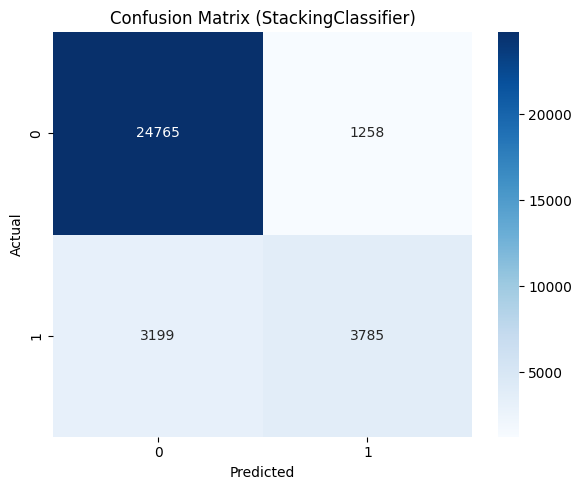

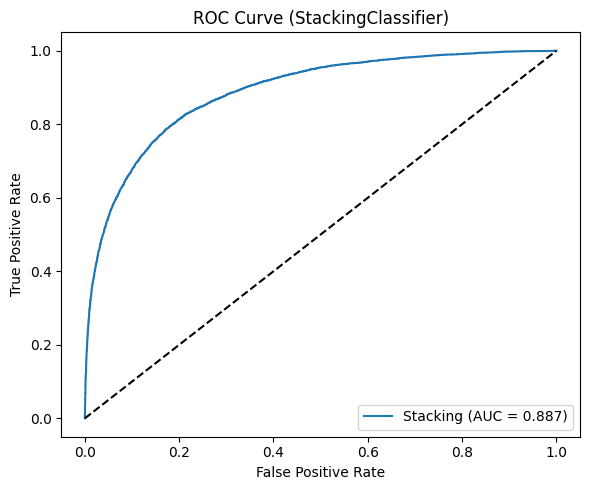

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (StackingClassifier)")
plt.tight_layout()
plt.show()

# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Stacking (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 분류 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (StackingClassifier)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### [2] 모델 시각화 -1) 혼동행렬
| 실제 / 예측 | 유지 (0) | 이탈 (1) |
| ------- | ------ | ------ |
| 유지 고객   | 24,765 | 1,258  |
| 이탈 고객   | 3,199  | 3,785  |

실제 이탈 고객 6,984명 중 3,785명을 정확히 예측 (Recall ≈ 54.2%)

FP 비율도 낮아 Precision ≈ 75.1% 수준

VotingClassifier보다도 약간 더 많은 이탈 고객을 포착

### [2] 모델 시각화 -2) ROC curve
AUC: 0.887

ROC 곡선이 왼쪽 위로 치우쳐 있어 이탈/비이탈 구분력이 뛰어남

Voting(0.886), XGBoost(0.890)와 비슷한 수준의 분류 성능 유지

/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/daldaguri/.local/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [17:13:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/daldaguri/.loc

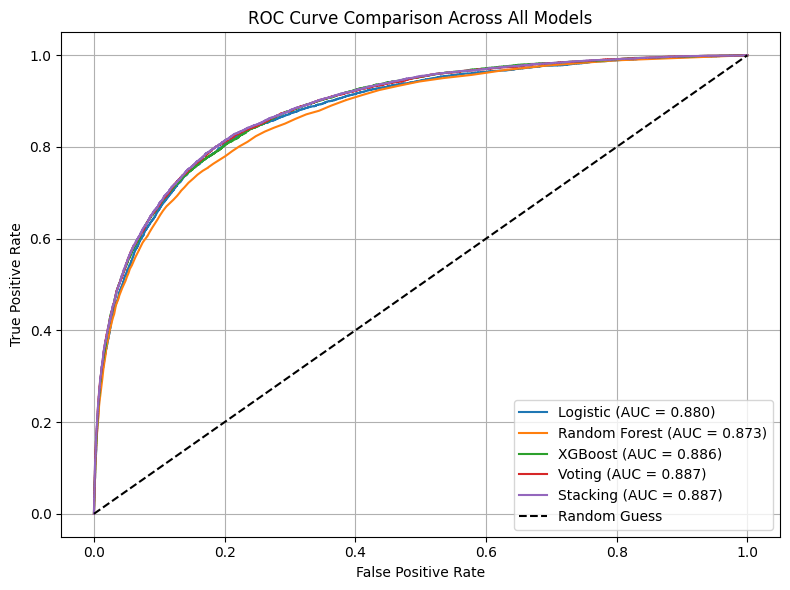

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 로지스틱 회귀
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# 랜덤포레스트
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train_scaled, y_train)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# XGBoost
xgb = XGBClassifier(tree_method="gpu_hist", gpu_id=0, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train)
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)
y_proba_vote = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(),
    passthrough=False,
    cv=5,
    n_jobs=-1
)
stacking_clf.fit(X_train_scaled, y_train)
y_proba_stack = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# --- ROC Curve 비교 시각화 ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_vote, tpr_vote, _ = roc_curve(y_test, y_proba_vote)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc(fpr_log, tpr_log):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc(fpr_xgb, tpr_xgb):.3f})")
plt.plot(fpr_vote, tpr_vote, label=f"Voting (AUC = {auc(fpr_vote, tpr_vote):.3f})")
plt.plot(fpr_stack, tpr_stack, label=f"Stacking (AUC = {auc(fpr_stack, tpr_stack):.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### [3] 모델링 결과 비교 - ROC curve
| 모델                | ROC-AUC | 해석 요약                |
| ----------------- | ------- | -------------------- |
| **Logistic**      | 0.880   | 해석력 뛰어나나 성능은 가장 낮음   |
| **Random Forest** | 0.873   | 다소 낮은 성능, 비선형 반영은 가능 |
| **XGBoost**       | 0.886   | 가장 높은 단일 모델 성능       |
| **Voting**        | 0.887   | 세 모델 평균, 성능 안정적      |
| **Stacking**      | 0.887   | 복합적 구조 반영 + 최고 수준 성능 |

Stacking과 Voting은 AUC 0.887로 최고 성능

XGBoost는 단일 모델 중 가장 뛰어난 성능

Logistic Regression은 해석력은 좋지만 분류력은 다소 낮음

Random Forest는 모든 면에서 무난하나 특출나진 않음



### [3] 모델링 결과 비교
- 요약 

| 항목           | 결과 요약                                               |
| ------------ | --------------------------------------------------- |
| 비교 모델     | Logistic, Random Forest, XGBoost, Voting, Stacking  |
| 평가 지표     | Accuracy, Precision, Recall, F1-score, ROC-AUC      |
| 최고 AUC    | **Voting = Stacking (0.887)** > **XGBoost (0.886)** |
| 최고 Recall | **XGBoost (0.55)** > Voting = Stacking (0.54)       |
| 균형 우수     | Voting & Stacking → Precision, F1, AUC 모두 안정적       |

- 성능 비교 표

| Model               | Accuracy | Precision (1) | Recall (1) | F1-score (1) | ROC-AUC |
| ------------------- | -------- | ------------- | ---------- | ------------ | ------- |
| Logistic Regression | 0.86     | 0.74          | 0.52       | 0.61         | 0.880   |
| Random Forest       | 0.86     | 0.72          | 0.53       | 0.61         | 0.873   |
| XGBoost             | 0.86     | 0.74          | 0.55       | 0.63         | 0.886   |
| Voting Classifier   | 0.86     | 0.75          | 0.54       | 0.63         | 0.887   |
| Stacking Classifier | 0.86     | 0.75          | 0.54       | 0.63         | 0.887   |



### [4] 결론
다양한 모델을 비교한 결과, StackingClassifier와 VotingClassifier가 가장 높은 ROC-AUC(0.887)를 기록하며 전반적인 예측 성능에서 가장 우수한 성과를 보였다.

특히 Stacking은 여러 모델의 장점을 통합하고 있으며, 이탈 고객 포착률(Recall)과 정확도(Precision)의 균형도 뛰어나 실무 적용에 가장 적합한 모델로 판단된다.

보완적으로는 LogisticRegression을 병행해 해석 가능성을 보완하거나, XGBoost 단일 모델을 경량화한 버전으로 활용하는 것도 가능하다.


In [ ]:
# 가장 성능적 장점을 지닌 StackingClassifier 기준, 이탈 확률 높은 고객 상위 10명
X_test_copy = X_test.copy()
X_test_copy['Exited_Prob'] = y_proba_stack
top_risk_customers = X_test_copy.sort_values(by='Exited_Prob', ascending=False).head(10)
top_risk_customers


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,...,sleeping_wealth,minimal_user,economic_maturity,churn_risk_score,relationship_value,activity_per_year,financial_engagement,prime_age,wealth_per_product,Exited_Prob
63374,535,45.0,2,128653.96,3,1.0,0.0,136619.31,False,True,...,1,0,5968648.575,3,273238.62,0.666667,4,1,88424.423333,0.954663
141443,605,49.0,3,131873.07,3,1.0,0.0,100722.72,False,True,...,1,0,5698596.855,3,302168.16,1.000000,4,1,77531.930000,0.954023
151100,550,49.0,1,108806.96,3,1.0,0.0,133031.96,False,True,...,1,0,5925053.540,3,133031.96,0.333333,4,1,80612.973333,0.953936
37699,738,50.0,1,132578.92,3,1.0,0.0,53477.76,False,True,...,1,0,4651417.000,3,53477.76,0.333333,4,1,62018.893333,0.953921
16067,682,45.0,5,130747.10,3,1.0,0.0,138380.74,False,True,...,1,0,6055376.400,3,691903.70,1.666667,4,1,89709.280000,0.953903
123144,713,47.0,7,148071.12,3,0.0,0.0,102525.72,False,True,...,1,0,5889025.740,3,717680.04,2.333333,4,1,83532.280000,0.953825
135517,740,45.0,7,118772.71,4,0.0,0.0,135853.62,False,True,...,1,0,5729092.425,3,950975.34,1.750000,5,1,63656.582500,0.953822
60712,619,52.0,3,171344.70,3,1.0,0.0,170821.19,False,True,...,1,0,8896313.140,3,512463.57,1.000000,4,1,114055.296667,0.953777
142026,651,59.0,0,154872.08,3,0.0,0.0,97416.34,True,True,...,1,0,7442508.390,3,0.00,0.000000,4,1,84096.140000,0.953775
51865,669,46.0,6,107199.75,3,0.0,0.0,145763.83,False,True,...,1,0,5818162.340,3,874582.98,2.000000,4,1,84321.193333,0.953773


- 이탈 가능성 높은 고객의 공통 특성 분석

| 특성                                 | 관찰된 경향                |
| ---------------------------------- | --------------------- |
| `NumOfProducts`: 3 이상              | → 많은 상품 보유자일수록 오히려 이탈 |
| `IsActiveMember`: 0                | → **비활성 고객**이 대부분     |
| `HasCrCard`: 일부 있음                 | 신용카드 여부는 혼재           |
| `EstimatedSalary`: 다양하지만 높음 비중도 있음 | → 소득만으로는 예측 어려움       |
| `Gender_Male`: 대부분 False (여성)      | → 성별 경향도 분석 가능        |

 이런 고객군을 비활성 고소득 다상품 여성군 등으로 정의하고, 이들에게 맞는 고객 유지 전략 수립 가능

/tmp/ipykernel_8140/2023764555.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


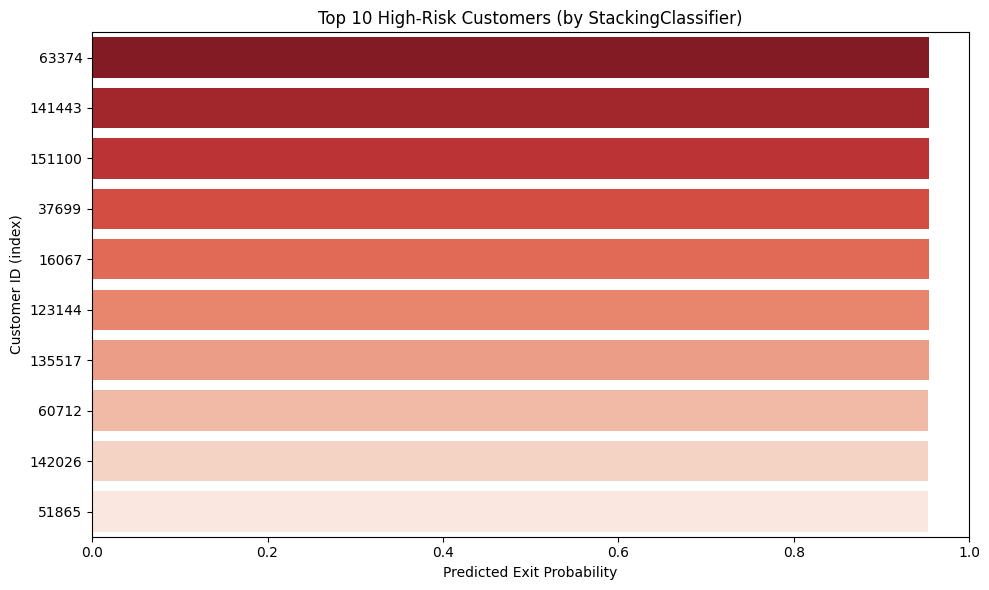

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exited_Prob 기준으로 상위 10명 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_risk_customers.index.astype(str),
    x=top_risk_customers["Exited_Prob"],
    palette="Reds_r"
)
plt.xlabel("Predicted Exit Probability")
plt.ylabel("Customer ID (index)")
plt.title("Top 10 High-Risk Customers (by StackingClassifier)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


위 시각화는 StackingClassifier 모델을 기반으로 예측된 이탈 확률이 가장 높은 고객 10명을 나타낸 것이다.
이 고객들은 대부분 다상품 보유, 낮은 활동성 등의 특성을 보이며, 즉각적인 유지 전략이 요구된다.
특히 Exited_Prob가 0.95 이상인 고객군은 우선 대응 대상으로 분류할 수 있다.